In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import scipy.signal as sig
from scipy.spatial.distance import pdist
import scikit_posthocs as sp
#import pingouin as pg
from scipy import stats
from scipy.stats import friedmanchisquare
from scipy.stats import mannwhitneyu 

In [2]:
input_path = r'/Volumes/Behaviour/Tailored 3sec 2P Trials'
output_path = r'/Volumes/Behaviour/Tailored 3sec 2P Trials/Phase Synchronization'
stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']
cfa_mice = ['2P07', '2P08', '2P09', '2P10', '2P11']
sessions = [session for session in os.listdir(input_path) if session.endswith('.csv')]
len(sessions)

48

In [7]:
# COMPUTE PHASE VARIANCES AND DISTANCES FOR WHOLE SESSION BASELINE AND POST STIMULUS: SHORT TRIALS
session_names = []
phase_variances = []
for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    clusters = pd.DataFrame()
    clusters['cell'] = cell_ids[:-1]
    
    pre_phase = pd.DataFrame()
    post_phase = pd.DataFrame()
    pre = pd.DataFrame()
    post = pd.DataFrame()
    trials = cells['identifier'].unique()
        
    for t in trials:
        trial = cells[cells['identifier']==t]
        preS = trial[:10]
        pre = pd.concat([pre, preS])
        postS = trial[10:]
        post = pd.concat([post, postS])
        
    for cid in cell_ids[:-1]:
        pre_trace = pre[cid]
        pre_trace_hill=sig.hilbert(pre_trace)
        pre_phase_trace=np.unwrap(np.angle(pre_trace_hill))
        pre_phase[cid] = pre_phase_trace
        
    mean_pre_d = np.mean(pdist(pre_phase.T))
    pre_phase['phase_variance'] = pre_phase.var(axis=1)
    mean_pre_var = pre_phase['phase_variance'].mean()
    phase_variances.append([ses_name, 'pre', mean_pre_var, mean_pre_d])
        
    for cid in cell_ids[:-1]:
        post_trace = post[cid]
        post_trace_hill=sig.hilbert(post_trace)
        post_phase_trace=np.unwrap(np.angle(post_trace_hill))
        post_phase[cid] = post_phase_trace
        
    mean_post_d = np.mean(pdist(post_phase.T))
    post_phase['phase_variance'] = post_phase.var(axis=1)
    mean_post_var = post_phase['phase_variance'].mean()
    phase_variances.append([ses_name, 'post', mean_post_var, mean_post_d])
            
cols = ['session', 'pre/post', 'mean phase variance', 'mean phase distance']
phase_vars = pd.DataFrame(phase_variances, columns=cols)
phase_vars.to_csv(os.path.join(output_path, 'phase variances entire session pre_post.csv'))



processing:  dF_F0_SHORT_2P06_Ses01.csv
processing:  dF_F0_SHORT_2P06_Ses02.csv
processing:  dF_F0_SHORT_2P06_Ses03.csv
processing:  dF_F0_SHORT_2P05_Ses04.csv
processing:  dF_F0_SHORT_2P06_Ses04.csv
processing:  dF_F0_SHORT_2P06_Ses05.csv
processing:  dF_F0_SHORT_2P05_Ses06.csv
processing:  dF_F0_SHORT_2P06_Ses06.csv
processing:  dF_F0_SHORT_2P05_Ses07.csv
processing:  dF_F0_SHORT_2P06_Ses07.csv
processing:  dF_F0_SHORT_2P07_Ses01.csv
processing:  dF_F0_SHORT_2P08_Ses01.csv
processing:  dF_F0_SHORT_2P07_Ses03.csv
processing:  dF_F0_SHORT_2P08_Ses02.csv
processing:  dF_F0_SHORT_2P07_Ses04.csv
processing:  dF_F0_SHORT_2P07_Ses05.csv
processing:  dF_F0_SHORT_2P08_Ses04.csv
processing:  dF_F0_SHORT_2P07_Ses06.csv
processing:  dF_F0_SHORT_2P08_Ses05.csv
processing:  dF_F0_SHORT_2P07_Ses07.csv
processing:  dF_F0_SHORT_2P08_Ses06.csv
processing:  dF_F0_SHORT_2P07_CFA.csv
processing:  dF_F0_SHORT_2P09_Ses01.csv
processing:  dF_F0_SHORT_2P08_CFA.csv
processing:  dF_F0_SHORT_2P11_Ses01.csv
proc

In [11]:
phase_vars['mouse'] = phase_vars['session'].apply(lambda x: x[:4])
phase_vars['cfa'] = phase_vars['session'].apply(lambda x: 'cfa' if 'CFA' in x else 'health')
phase_vars.to_csv(os.path.join(output_path, 'phase variances entire session pre_post.csv'))
phase_vars_cfa_mice = phase_vars.loc[phase_vars['mouse'].isin(cfa_mice)]
phase_vars_cfa_mice.head()

,session,pre/post,mean phase variance,mean phase distance,mouse,cfa
20,2P07_Ses01,pre,69.354373,153.992529,2P07,health
21,2P07_Ses01,post,42.254099,115.314798,2P07,health
22,2P08_Ses01,pre,105.485160,200.184156,2P08,health
23,2P08_Ses01,post,47.311691,127.854348,2P08,health
24,2P07_Ses03,pre,87.814650,171.011450,2P07,health


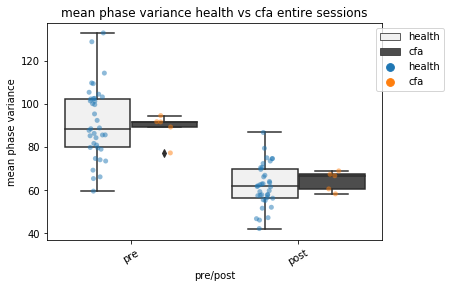

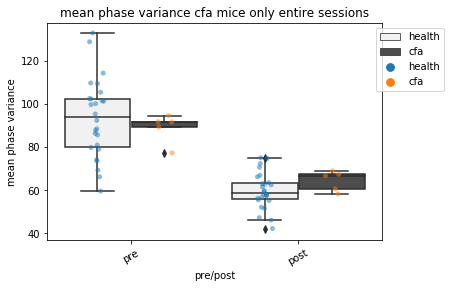

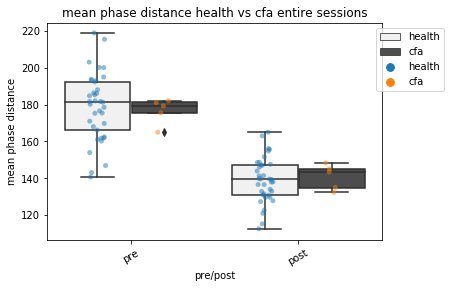

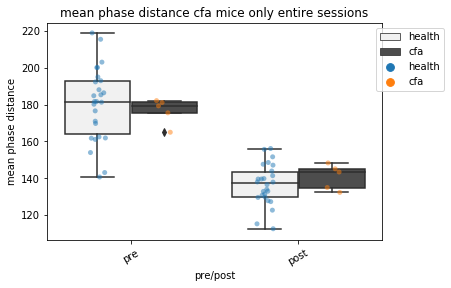

In [13]:

ax = sns.stripplot(x="pre/post", y="mean phase variance", hue="cfa", data=phase_vars, alpha=0.5, dodge=True)
ax = sns.boxplot(x="pre/post", y="mean phase variance", hue="cfa", data=phase_vars, color='.3')
#ax.legend([],[], frameon=False)
ax.legend(bbox_to_anchor= (1.2,1))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean phase variance health vs cfa entire sessions')
plt.savefig(os.path.join(output_path, 'phase variance entire sessions health_cfa.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="pre/post", y="mean phase variance", hue="cfa", data=phase_vars_cfa_mice, alpha=0.5, dodge=True)
ax = sns.boxplot(x="pre/post", y="mean phase variance", hue="cfa", data=phase_vars_cfa_mice, color='.3')
#ax.legend([],[], frameon=False)
ax.legend(bbox_to_anchor= (1.2,1))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean phase variance cfa mice only entire sessions')
plt.savefig(os.path.join(output_path, 'phase variance entire cfa sessions health_cfa.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="pre/post", y="mean phase distance", hue="cfa", data=phase_vars, alpha=0.5, dodge=True)
ax = sns.boxplot(x="pre/post", y="mean phase distance", hue="cfa", data=phase_vars, color='.3')
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean phase distance health vs cfa entire sessions')
plt.savefig(os.path.join(output_path, 'phase distance entire sessions health_cfa.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="pre/post", y="mean phase distance", hue="cfa", data=phase_vars_cfa_mice, alpha=0.5, dodge=True)
ax = sns.boxplot(x="pre/post", y="mean phase distance", hue="cfa", data=phase_vars_cfa_mice, color='.3')
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean phase distance cfa mice only entire sessions')
plt.savefig(os.path.join(output_path, 'phase distance entire cfa sessions health_cfa.png'), bbox_inches='tight')
plt.show()

In [17]:
var_pre_health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='pre') & (phase_vars_cfa_mice['cfa']=='health')]['mean phase variance']
var_pre_cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='pre') & (phase_vars_cfa_mice['cfa']=='cfa')]['mean phase variance']

dis_pre_health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='pre') & (phase_vars_cfa_mice['cfa']=='health')]['mean phase distance']
dis_pre_cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='pre') & (phase_vars_cfa_mice['cfa']=='cfa')]['mean phase distance']

var_post_health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='post') & (phase_vars_cfa_mice['cfa']=='health')]['mean phase variance']
var_post_cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='post') & (phase_vars_cfa_mice['cfa']=='cfa')]['mean phase variance']

dis_post_health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='post') & (phase_vars_cfa_mice['cfa']=='health')]['mean phase distance']
dis_post_cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='post') & (phase_vars_cfa_mice['cfa']=='cfa')]['mean phase distance']

In [21]:
U1, p = mannwhitneyu(np.array(var_pre_health), np.array(var_pre_cfa))
print('baseline variance: ', U1, p)

U1, p = mannwhitneyu(np.array(dis_pre_health), np.array(dis_pre_cfa))
print('baseline distance: ', U1, p)

U1, p = mannwhitneyu(np.array(var_post_health), np.array(var_post_cfa))
print('stimulus variance: ', U1, p)

U1, p = mannwhitneyu(np.array(dis_post_health), np.array(dis_post_cfa))
print('stimulus vdistance: ', U1, p)



baseline variance:  54.0 0.28639732555624636
baseline distance:  51.0 0.2342056757064503
stimulus variance:  37.0 0.0698395707149984
stimulus vdistance:  48.0 0.1877569947261642


In [2]:
input_path = r'/Volumes/Behaviour/Tailored 90sec 2P Trials'
output_path = r'/Volumes/Behaviour/Tailored 90sec 2P Trials/Phase Synchronization'
stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']
cfa_mice = ['2P07', '2P08', '2P09', '2P10', '2P11']
sessions = [session for session in os.listdir(input_path) if session.endswith('.csv')]
len(sessions)

47

In [5]:
# COMPUTE PHASE VARIANCES AND DISTANCES FOR WHOLE SESSION BASELINE AND POST STIMULUS: LONG TRIALS
session_names = []
phase_variances = []
for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    clusters = pd.DataFrame()
    clusters['cell'] = cell_ids[:-1]
    
    pre_phase = pd.DataFrame()
    post_phase = pd.DataFrame()
    pre = pd.DataFrame()
    post = pd.DataFrame()
    trials = cells['identifier'].unique()
        
    for t in trials:
        trial = cells[cells['identifier']==t]
        preS = trial[:153]
        pre = pd.concat([pre, preS])
        postS = trial[183:]
        post = pd.concat([post, postS])
        
    for cid in cell_ids[:-1]:
        pre_trace = pre[cid]
        pre_trace_hill=sig.hilbert(pre_trace)
        pre_phase_trace=np.unwrap(np.angle(pre_trace_hill))
        pre_phase[cid] = pre_phase_trace
        
    mean_pre_d = np.mean(pdist(pre_phase.T))
    pre_phase['phase_variance'] = pre_phase.var(axis=1)
    mean_pre_var = pre_phase['phase_variance'].mean()
    phase_variances.append([ses_name, 'pre', mean_pre_var, mean_pre_d])
        
    for cid in cell_ids[:-1]:
        post_trace = post[cid]
        post_trace_hill=sig.hilbert(post_trace)
        post_phase_trace=np.unwrap(np.angle(post_trace_hill))
        post_phase[cid] = post_phase_trace
        
    mean_post_d = np.mean(pdist(post_phase.T))
    post_phase['phase_variance'] = post_phase.var(axis=1)
    mean_post_var = post_phase['phase_variance'].mean()
    phase_variances.append([ses_name, 'post', mean_post_var, mean_post_d])
            
cols = ['session', 'pre/post', 'mean phase variance', 'mean phase distance']
phase_vars = pd.DataFrame(phase_variances, columns=cols)
phase_vars.to_csv(os.path.join(output_path, 'phase variances entire session pre_post long trials.csv'))




processing:  dF_F0_LONG_2P06_Ses01.csv


/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


processing:  dF_F0_LONG_2P06_Ses02.csv
processing:  dF_F0_LONG_2P06_Ses03.csv
processing:  dF_F0_LONG_2P05_Ses04.csv
processing:  dF_F0_LONG_2P06_Ses04.csv
processing:  dF_F0_LONG_2P06_Ses05.csv
processing:  dF_F0_LONG_2P05_Ses06.csv
processing:  dF_F0_LONG_2P06_Ses06.csv
processing:  dF_F0_LONG_2P05_Ses07.csv
processing:  dF_F0_LONG_2P06_Ses07.csv
processing:  dF_F0_LONG_2P07_Ses01.csv
processing:  dF_F0_LONG_2P08_Ses01.csv
processing:  dF_F0_LONG_2P07_Ses03.csv
processing:  dF_F0_LONG_2P08_Ses02.csv
processing:  dF_F0_LONG_2P07_Ses04.csv
processing:  dF_F0_LONG_2P07_Ses05.csv
processing:  dF_F0_LONG_2P08_Ses04.csv
processing:  dF_F0_LONG_2P07_Ses06.csv
processing:  dF_F0_LONG_2P08_Ses05.csv
processing:  dF_F0_LONG_2P07_Ses07.csv
processing:  dF_F0_LONG_2P08_Ses06.csv
processing:  dF_F0_LONG_2P07_CFA.csv
processing:  dF_F0_LONG_2P09_Ses01.csv
processing:  dF_F0_LONG_2P08_CFA.csv
processing:  dF_F0_LONG_2P11_Ses01.csv
processing:  dF_F0_LONG_2P10_Ses01.csv
processing:  dF_F0_LONG_2P09_

In [6]:
phase_vars['mouse'] = phase_vars['session'].apply(lambda x: x[:4])
phase_vars['cfa'] = phase_vars['session'].apply(lambda x: 'cfa' if 'CFA' in x else 'health')
phase_vars.to_csv(os.path.join(output_path, 'phase variances entire session pre_post long trials.csv'))
phase_vars_cfa_mice = phase_vars.loc[phase_vars['mouse'].isin(cfa_mice)]
phase_vars_cfa_mice.head()

,session,pre/post,mean phase variance,mean phase distance,mouse,cfa
20,2P07_Ses01,pre,1508.093672,2752.365672,2P07,health
21,2P07_Ses01,post,4004.176839,6714.750062,2P07,health
22,2P08_Ses01,pre,1874.047557,3177.990133,2P08,health
23,2P08_Ses01,post,5791.275835,8457.585848,2P08,health
24,2P07_Ses03,pre,1799.431981,2944.138802,2P07,health


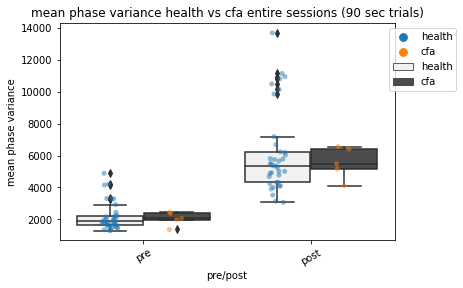

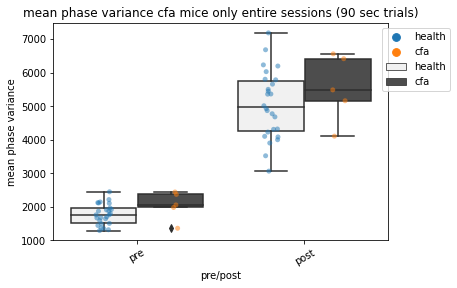

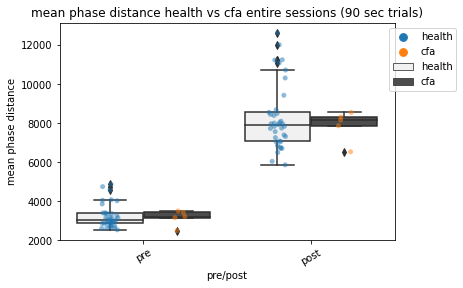

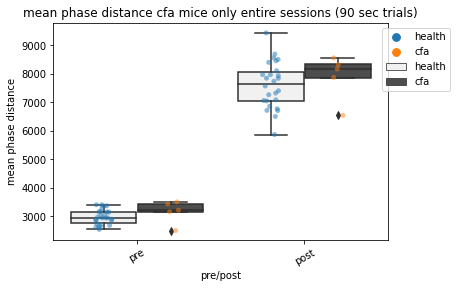

In [7]:
ax = sns.stripplot(x="pre/post", y="mean phase variance", hue="cfa", data=phase_vars, alpha=0.5, dodge=True)
ax = sns.boxplot(x="pre/post", y="mean phase variance", hue="cfa", data=phase_vars, color='.3')
#ax.legend([],[], frameon=False)
ax.legend(bbox_to_anchor= (1.2,1))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean phase variance health vs cfa entire sessions (90 sec trials)')
plt.savefig(os.path.join(output_path, 'phase variance entire sessions health_cfa long.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="pre/post", y="mean phase variance", hue="cfa", data=phase_vars_cfa_mice, alpha=0.5, dodge=True)
ax = sns.boxplot(x="pre/post", y="mean phase variance", hue="cfa", data=phase_vars_cfa_mice, color='.3')
#ax.legend([],[], frameon=False)
ax.legend(bbox_to_anchor= (1.2,1))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean phase variance cfa mice only entire sessions (90 sec trials)')
plt.savefig(os.path.join(output_path, 'phase variance entire cfa sessions health_cfa long.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="pre/post", y="mean phase distance", hue="cfa", data=phase_vars, alpha=0.5, dodge=True)
ax = sns.boxplot(x="pre/post", y="mean phase distance", hue="cfa", data=phase_vars, color='.3')
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean phase distance health vs cfa entire sessions (90 sec trials)')
plt.savefig(os.path.join(output_path, 'phase distance entire sessions health_cfa long.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="pre/post", y="mean phase distance", hue="cfa", data=phase_vars_cfa_mice, alpha=0.5, dodge=True)
ax = sns.boxplot(x="pre/post", y="mean phase distance", hue="cfa", data=phase_vars_cfa_mice, color='.3')
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean phase distance cfa mice only entire sessions (90 sec trials)')
plt.savefig(os.path.join(output_path, 'phase distance entire cfa sessions health_cfa long.png'), bbox_inches='tight')
plt.show()

In [8]:
var_pre_health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='pre') & (phase_vars_cfa_mice['cfa']=='health')]['mean phase variance']
var_pre_cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='pre') & (phase_vars_cfa_mice['cfa']=='cfa')]['mean phase variance']

dis_pre_health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='pre') & (phase_vars_cfa_mice['cfa']=='health')]['mean phase distance']
dis_pre_cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='pre') & (phase_vars_cfa_mice['cfa']=='cfa')]['mean phase distance']

var_post_health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='post') & (phase_vars_cfa_mice['cfa']=='health')]['mean phase variance']
var_post_cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='post') & (phase_vars_cfa_mice['cfa']=='cfa')]['mean phase variance']

dis_post_health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='post') & (phase_vars_cfa_mice['cfa']=='health')]['mean phase distance']
dis_post_cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['pre/post']=='post') & (phase_vars_cfa_mice['cfa']=='cfa')]['mean phase distance']

In [9]:
U1, p = mannwhitneyu(np.array(var_pre_health), np.array(var_pre_cfa))
print('baseline variance: ', U1, p)

U1, p = mannwhitneyu(np.array(dis_pre_health), np.array(dis_pre_cfa))
print('baseline distance: ', U1, p)

U1, p = mannwhitneyu(np.array(var_post_health), np.array(var_post_cfa))
print('stimulus variance: ', U1, p)

U1, p = mannwhitneyu(np.array(dis_post_health), np.array(dis_post_cfa))
print('stimulus distance: ', U1, p)



baseline variance:  37.0 0.1435221969148554
baseline distance:  37.0 0.1435221969148554
stimulus variance:  45.0 0.30512444750487017
stimulus distance:  49.0 0.41681821659574714
